# Info
Purpose:

    To Calculate aerosol optical properties for aerosol above cloud reitrewvals using MODIS and VIIRS
    Using the wavelengths: 
    0.47, 0.55, 0.67, 0.86, 1.24, 2.1µm
    
    - Using the retrieved size distributions
    - retrieval results of refractive index (imaginary and real) at wavelengths: 400, 500, 675, 870, 995 nm


Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - libradtran

Needed Files:
  - netcdf of aeroinv from ORACLES
  - ...

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-09-12
    Modified:Samuel LeBlanc, Santa Cruz, CA, 2022-09-21
             - added new wavelengths and storing of the phase function
             


# Prepare python environment

In [1]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import scipy.interpolate as si
import netCDF4 as nc

In [164]:
name = 'sunsat_ORACLES2016'
vv = 'v3'
fp = getpath(name)


Return path named:  sunsat_ORACLES2016 /data/sunsat/ORACLES_2016/


In [3]:
fp_bin = getpath('uvspec_bin')

Return path named:  uvspec_bin /home/sam/libradtran/libRadtran-2.0.2/bin/


In [4]:
fp_rtm0 = getpath('rtm')
fp_rtm = fp_rtm0 +'TASNPP_mie/'

Return path named:  rtm /scratch/rtm/


In [5]:
if not os.path.exists(fp_rtm): 
    os.mkdir(fp_rtm)

# Load files

In [6]:
f = fp + 'data_archival/AEROINV_nc_R0/NC_FORMAT_NETCDF4_CLASSIC/4STAR-aeroinv_P3_2016_R0.nc'

In [7]:
ae,ae_dict = lu.load_netcdf(f,everything=True)

Reading file: /data/sunsat/ORACLES_2016/data_archival/AEROINV_nc_R0/NC_FORMAT_NETCDF4_CLASSIC/4STAR-aeroinv_P3_2016_R0.nc
Outputting the Data subdatasets:
0: base_time
1: time_offset
2: time
3: wavelength
4: radius
5: psd
6: QA_level
7: sphericity
8: sphericity_err
9: PF_angle
10: sca_angle
11: n_real
12: n_imag
13: SSA
14: AOD_fit_total
15: AOD_fit_fine
16: AOD_fit_coarse
17: AOD_meas
18: AAOD
19: TOD_meas
20: TOD_fit
21: TOD_meas_minus_fit
22: AGOD
23: sfc_alb
24: g_total
25: g_fine
26: g_coarse
27: PF_total
28: PF_fine
29: PF_coarse
30: normalized_sky_radiance
31: normalized_sky_radiance_fit
32: sky_radiance_fit_error
33: scan_tag
34: scan_type
35: Lat
36: Lon
37: GPS_Altitude
38: Heading
39: Pitch
40: Roll
41: GPS_Altitude_std
42: Heading_std
43: Pitch_std
44: Roll_std
45: T_static
46: P_static
47: RH
48: SAZ
49: SZA
50: SEL
51: m_ray
52: PWV
[b'base_time', b'time_offset', b'time', b'wavelength', b'radius', b'psd', b'QA_level', b'sphericity', b'sphericity_err', b'PF_angle', b'sca_a

In [8]:
len(ae[b'time'])

86

In [9]:
ae_dict[b'scan_tag']

<class 'netCDF4._netCDF4.Variable'>
float64 scan_tag(time)
    long_name: sky scan file tag
    units: unitless
unlimited dimensions: time
current shape = (86,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [10]:
ae[b'scan_tag']

masked_array(data=[ 13.,  14.,  68., 117., 118., 124., 127., 133., 134.,
                    10.,  18.,  19.,  22.,  23.,  26.,  27.,  34.,  46.,
                    47.,  56.,  61.,  72.,  73.,  82.,  93.,  19.,  49.,
                    32.,  33.,  39.,  40.,  55.,  68.,  69.,  72.,  73.,
                    79.,  80.,  11.,  50.,  61.,  25.,  44.,  45.,  48.,
                    72.,  73.,  76.,  77.,   4.,   5.,  11.,  14.,  17.,
                    43.,  10.,  26.,  27.,  30.,  33.,  36.,  39.,  42.,
                    62.,  75., 143., 149., 152., 169., 170., 179., 182.,
                   185.,  31.,  35.,  89.,  20.,  21.,  34.,  59.,  62.,
                    63.,  66.,  67.,  80.,  25.],
             mask=False,
       fill_value=1e+20)

## Extra meta information

In [14]:
sk_meta = sio.loadmat(fp+'data_processed/starskies/skyscans_ORACLES2016_moredata.mat')

In [16]:
sk_meta.keys()

dict_keys(['__header__', '__version__', '__globals__', 'skyscan_vars', 'skyscans_all', 'Wavelength', 'skyscans_qcflags', 'skyscans_meta'])

In [18]:
sk_meta['skyscans_meta'].shape

(174, 6)

In [68]:
sk_meta['skyscans_qcflags'].shape

(174, 1)

In [55]:
sk_meta['skyscan_vars'][0]

array([array(['date'], dtype='<U4'), array(['filenum'], dtype='<U7'),
       array(['avg lat'], dtype='<U7'), array(['avg lon'], dtype='<U7'),
       array(['altitude'], dtype='<U8'), array(['time'], dtype='<U4'),
       array(['aod'], dtype='<U3'), array(['aaod'], dtype='<U4'),
       array(['ssa_total'], dtype='<U9'),
       array(['ssa_fine'], dtype='<U8'),
       array(['ssa_coarse'], dtype='<U10'),
       array(['ext_fine'], dtype='<U8'),
       array(['ext_coarse'], dtype='<U10'), array(['g_tot'], dtype='<U5'),
       array(['g_fine'], dtype='<U6'), array(['g_coarse'], dtype='<U8'),
       array(['sfc_alb'], dtype='<U7'),
       array(['refractive_index_imaginary_r'], dtype='<U28'),
       array(['refractive_index_real_r'], dtype='<U23'),
       array(['psd'], dtype='<U3'), array(['radius'], dtype='<U6'),
       array(['Sphericity'], dtype='<U10'),
       array(['Sphericity_err'], dtype='<U14')], dtype=object)

In [44]:
sk_meta['skyscans_meta'][0,:]

array([ 2.0160831e+07,  9.0000000e+00, -2.0839250e+01,  1.0847450e+01,
        1.0450000e+03,  8.5800000e+02])

In [47]:
sk_meta['skyscans_all'].shape

(174, 25)

In [191]:
sk_meta['skyscans_all'][0,24]

array([[array(['AOD(400)=0.1627 <0.2, invalid retrieval'], dtype='<U39')],
       [array(['max angle=92.9; pass.'], dtype='<U21')],
       [array(['mean sky error=2.8629; pass.'], dtype='<U28')]],
      dtype=object)

In [64]:
sk_meta['days'] = [dd[0][0] for dd in sk_meta['skyscans_all'][:,0]]

In [66]:
sk_meta['filenum'] = [dd[0][0] for dd in sk_meta['skyscans_all'][:,1]]

## Map the extra meta information to the skyscans in the file

In [69]:
ae[b'scan_tag']

masked_array(data=[ 13.,  14.,  68., 117., 118., 124., 127., 133., 134.,
                    10.,  18.,  19.,  22.,  23.,  26.,  27.,  34.,  46.,
                    47.,  56.,  61.,  72.,  73.,  82.,  93.,  19.,  49.,
                    32.,  33.,  39.,  40.,  55.,  68.,  69.,  72.,  73.,
                    79.,  80.,  11.,  50.,  61.,  25.,  44.,  45.,  48.,
                    72.,  73.,  76.,  77.,   4.,   5.,  11.,  14.,  17.,
                    43.,  10.,  26.,  27.,  30.,  33.,  36.,  39.,  42.,
                    62.,  75., 143., 149., 152., 169., 170., 179., 182.,
                   185.,  31.,  35.,  89.,  20.,  21.,  34.,  59.,  62.,
                    63.,  66.,  67.,  80.,  25.],
             mask=False,
       fill_value=1e+20)

In [87]:
from datetime import datetime

In [118]:
days = []
for t in ae[b'time']:
    x =  datetime.fromtimestamp(datetime(2016,8,31).timestamp()+t)
    days.append(x.year*10000+x.month*100+x.day)

In [120]:
days

[20160831,
 20160831,
 20160831,
 20160831,
 20160831,
 20160831,
 20160831,
 20160831,
 20160831,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160902,
 20160904,
 20160904,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160906,
 20160908,
 20160910,
 20160910,
 20160912,
 20160912,
 20160912,
 20160912,
 20160912,
 20160912,
 20160912,
 20160912,
 20160914,
 20160914,
 20160914,
 20160914,
 20160914,
 20160914,
 20160918,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160920,
 20160924,
 20160924,
 20160924,
 20160925,
 20160925,
 20160925,
 20160925,
 20160925,
 20160925,
 20160925,
 20160925,
 20160925,
 20160927]

In [161]:
qc_flags = [4.0]*len(days)
for i,da in list(enumerate(days)):
    ig = [(da==dk)&(int(ae[b'scan_tag'][i])==sk_meta['filenum'][j]) for j,dk in enumerate(sk_meta['days'])] 
    if any(ig): qc_flags[i] = (sk_meta['skyscans_qcflags'][ig][0][0])

In [163]:
qc_flags

[1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 3.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 1.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.75,
 0.5,
 0.5,
 0.5,
 4.0,
 0.5,
 0.5,
 0.5,
 0.5,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.5,
 0.5,
 0.0,
 0.5,
 0.0,
 0.5,
 0.0,
 1.0]

# Run through each retrieval and make input files

## Prep functions for printing size distribution

From the libradtran documentation for mie size distribution file:  
>Specify a two column file, r [micron], dn(r)/dr, which describes a size distribution

In [12]:
def print_size_dist_file(fname,r,dnr):
    with open(fname,'w') as f:
        for ir,rr in list(enumerate(r)):
            f.write('{:3.10f} {:3.10f}\n'.format(rr,dnr[ir]))

In [13]:
ae_dict[b'radius']

<class 'netCDF4._netCDF4.Variable'>
float64 radius(radius)
    long_name: particle radius
    units: um
unlimited dimensions: 
current shape = (22,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [14]:
ae_dict[b'psd']

<class 'netCDF4._netCDF4.Variable'>
float64 psd(time, radius)
    long_name: particle size distribution
    units: dV/dlnR
    source: retrieval
unlimited dimensions: time
current shape = (86, 22)
filling on, default _FillValue of 9.969209968386869e+36 used

In [15]:
def convert_dvlnr_to_dndr(psd,r):
     # All about that conversion from the volume size distribution of dV(r)/dln(r) to number size distribution dN(r)/dr
    Nr = psd/(4.0*np.pi/3.0)
    for i,rr in list(enumerate(r)):
        Nr[i] = Nr[i]/rr**4.0
    return Nr

In [16]:
print_size_dist_file(fp_rtm+'mie_tester.psd',ae[b'radius'],convert_dvlnr_to_dndr(ae[b'psd'][0,:],ae[b'radius']))

## Prep function for printing index of refraction

Update from Kerry Meyer's email on Sept 21, 2022.  

> Thanks, Sam, this is helpful. Do you have the extrapolated phase functions also? And I hate to do this, but can the wavelength range be extended in both directions? I’d like to accommodate the VIIRS 2.25µm channel, and use the spectral response functions to compute band-weighted averages for each MODIS and VIIRS channel. So perhaps adding something like 400nm on the short end (which I guess is the exact 4STAR wavelength there) and 2300nm on the long end – that should encompass most of the response function ranges for MODIS and VIIRS.
>
> I’ll also need your input on how best to QA filter these scans. I see a “QA_level” dataset that I assume should be part of that.
>
>Kerry

In [17]:
ae_dict[b'n_real']

<class 'netCDF4._netCDF4.Variable'>
float64 n_real(time, wavelength)
    long_name: refractive index, real
    units: unitless
    source: retrieval
unlimited dimensions: time
current shape = (86, 5)
filling on, default _FillValue of 9.969209968386869e+36 used

In [18]:
ae_dict[b'n_imag']

<class 'netCDF4._netCDF4.Variable'>
float64 n_imag(time, wavelength)
    long_name: refractive index, imaginary
    units: unitless
    source: retrieval
unlimited dimensions: time
current shape = (86, 5)
filling on, default _FillValue of 9.969209968386869e+36 used

In [19]:
ae_dict[b'wavelength']

<class 'netCDF4._netCDF4.Variable'>
float64 wavelength(wavelength)
    long_name: wavelength
    units: nm
unlimited dimensions: 
current shape = (5,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [31]:
def spline_wavelength_extend(val,wavelen,new_wavelen,su=0.0006,k=2):
    # to calculate a new spline fit to the refractive index
    val_fx = si.CubicSpline(np.append(wavelen,wavelen[-1]+600.0),np.append(val,val[-1]),bc_type='natural',extrapolate=True)
    return val_fx(new_wavelen)

In [32]:
if vv == 'v1':
    wave_out = np.array([470.0, 550.0, 670.0, 860.0, 1240.0, 2100.0])
elif vv == 'v2':
    wave_out = np.array([400.0, 470.0, 550.0, 670.0, 860.0, 1240.0, 2100.0, 2300.0])

<IPython.core.display.Javascript object>


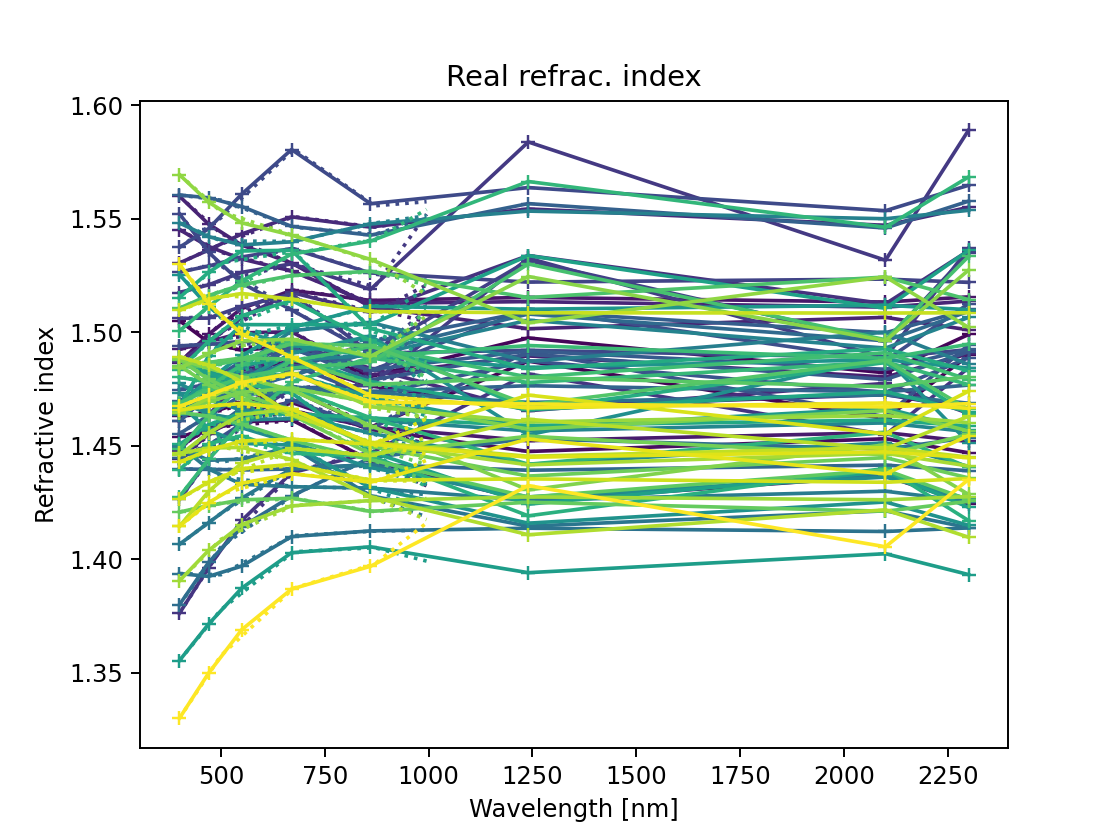

Text(0, 0.5, 'Refractive index')

In [33]:
fig,ax = plt.subplots(1,1)

for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'n_real'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,spline_wavelength_extend(ae[b'n_real'][it,:],ae[b'wavelength'],wave_out),
             '+-',c=plt.cm.viridis(it*3))
    
plt.title('Real refrac. index')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index')
    

<IPython.core.display.Javascript object>


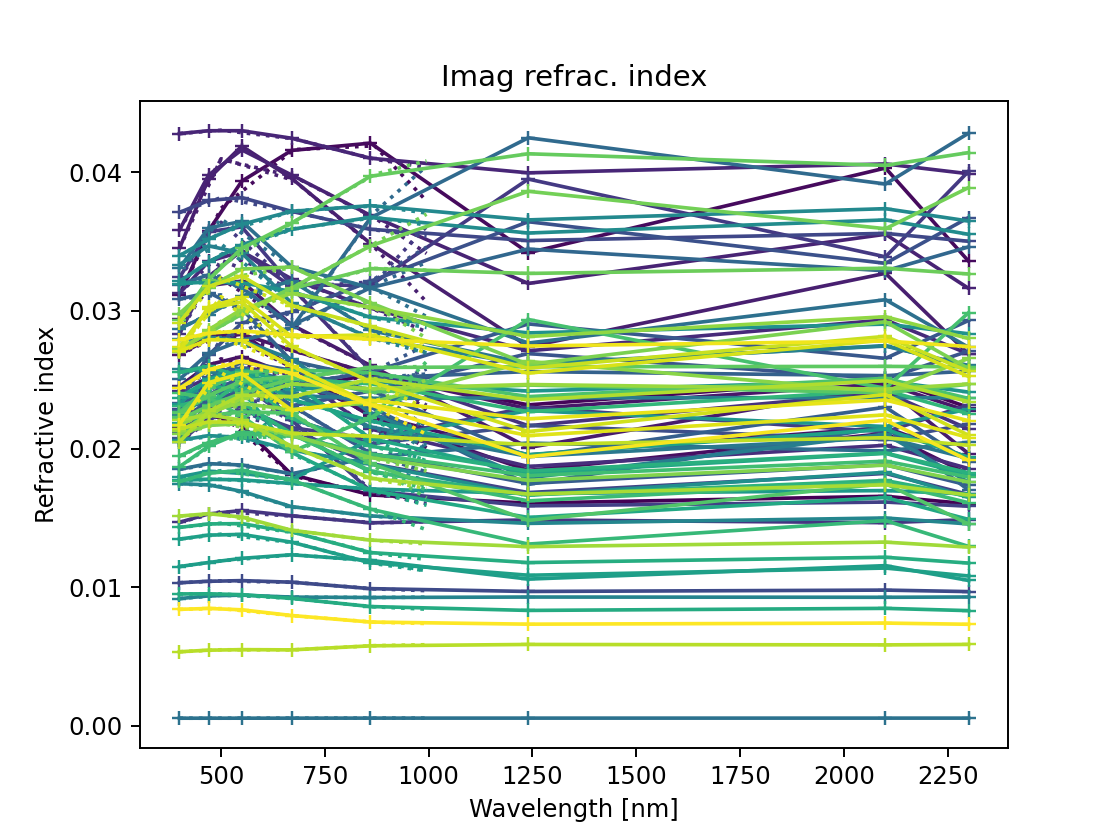

Text(0, 0.5, 'Refractive index')

In [34]:
plt.figure()
for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'n_imag'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,spline_wavelength_extend(ae[b'n_imag'][it,:],ae[b'wavelength'],wave_out),
         '+-',c=plt.cm.viridis(it*3))
    
plt.title('Imag refrac. index')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index')
    

In [35]:
def print_refrac_file(fname,wavelength,n_real,n_imag):
    #wavelength in nm, n_real and n_imag needs to be positive
    
    with open(fname,'w') as f:
        for iw,w in list(enumerate(wavelength)):
            f.write('{:4.3f} {:3.12f} {:3.12f}\n'.format(w,abs(n_real[iw]),abs(n_imag[iw])))

In [36]:
itest = 0
print_refrac_file(fp_rtm+'mie_tester.ref',wave_out,
                     spline_wavelength_extend(ae[b'n_real'][itest,:],ae[b'wavelength'],wave_out),
                     spline_wavelength_extend(ae[b'n_imag'][itest,:],ae[b'wavelength'],wave_out))

## Mie input file function

In [41]:
def mie_input(fname,refrac_file_name,size_dist_file_name,program='MIEV0',nmom=None):
    #simple mie input file program
     with open(fname,'w') as f:
            f.write('mie_program {}\n'.format(program))
            f.write('refrac file {}\n'.format(refrac_file_name))
            f.write('size_distribution_file {}\n'.format(size_dist_file_name))
            if nmom:
                f.write('nmom {}\n'.format(nmom))
            
    

In [38]:
mie_input(fp_rtm+'mie_tester.inp',fp_rtm+'mie_tester.ref',fp_rtm+'mie_tester.psd')

# Run through and make input files for scans

In [42]:
base = 'mie_ORACLES2016_expansion_{}'.format(vv)
f_list = fp_rtm+base+'_list.sh'
with open(f_list,'w') as f:
    for it,tt in list(enumerate(ae[b'time'])):
        basename = base+'_{:03.0f}'.format(it)
        print_refrac_file(fp_rtm+basename+'.ref',wave_out,
                         spline_wavelength_extend(ae[b'n_real'][it,:],ae[b'wavelength'],wave_out),
                         spline_wavelength_extend(ae[b'n_imag'][it,:],ae[b'wavelength'],wave_out))
        print_size_dist_file(fp_rtm+basename+'.psd',ae[b'radius'],convert_dvlnr_to_dndr(ae[b'psd'][it,:],ae[b'radius']))
        mie_input(fp_rtm+basename+'.inp',fp_rtm+basename+'.ref',fp_rtm+basename+'.psd',nmom=1500)
        f.write('{bin_path}mie < {inp} > {out}\n'.format(bin_path=fp_bin,inp=fp_rtm+basename+'.inp',out=fp_rtm+basename+'.out'))

In [43]:
%ls $fp_rtm

mie_ORACLES2016_expansion_000.inp  mie_ORACLES2016_expansion_076.psd
mie_ORACLES2016_expansion_000.out  mie_ORACLES2016_expansion_076.ref
mie_ORACLES2016_expansion_000.psd  mie_ORACLES2016_expansion_077.inp
mie_ORACLES2016_expansion_000.ref  mie_ORACLES2016_expansion_077.out
mie_ORACLES2016_expansion_001.inp  mie_ORACLES2016_expansion_077.psd
mie_ORACLES2016_expansion_001.out  mie_ORACLES2016_expansion_077.ref
mie_ORACLES2016_expansion_001.psd  mie_ORACLES2016_expansion_078.inp
mie_ORACLES2016_expansion_001.ref  mie_ORACLES2016_expansion_078.out
mie_ORACLES2016_expansion_002.inp  mie_ORACLES2016_expansion_078.psd
mie_ORACLES2016_expansion_002.out  mie_ORACLES2016_expansion_078.ref
mie_ORACLES2016_expansion_002.psd  mie_ORACLES2016_expansion_079.inp
mie_ORACLES2016_expansion_002.ref  mie_ORACLES2016_expansion_079.out
mie_ORACLES2016_expansion_003.inp  mie_ORACLES2016_expansion_079.psd
mie_ORACLES2016_expansion_003.out  mie_ORACLES2016_expansion_079.ref
mie_ORACLES2016_expansion_003.psd 

In [44]:
!parallel --jobs=22 --bar < $f_list

0% 0:86=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_001.ref
1% 1:85=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_000.ref
2% 2:84=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_002.ref
3% 3:83=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_004.ref
4% 4:82=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_003.ref
5% 5:81=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_e

59% 51:35=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_051.ref
60% 52:34=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_060.ref
61% 53:33=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_052.ref
62% 54:32=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_053.ref
63% 55:31=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_054.ref
65% 56:30=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 8 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_e

## Read the mie output files

In [45]:
fname = fp_rtm+basename+'.out'

In [46]:
outs = np.genfromtxt(fname)

In [50]:
len(outs[0,7:]

0.7027928

In [51]:
def read_mie_output(fname):
    # read the default ascii output file from mie code
    outs = np.genfromtxt(fname)
    d = {}
    d['wavelength'] = outs[:,0]
    d['n_real'] = outs[:,1]
    d['n_imag'] = outs[:,2]
    d['qext'] = outs[:,3]
    d['ssa'] = outs[:,4]
    d['asym'] = outs[:,5]
    d['spike'] = outs[:,6]
    d['pmom'] = outs[:,7:]
    return d

In [52]:
dats = []
for it,tt in list(enumerate(ae[b'time'])):
    basename = base+'_{:03.0f}'.format(it)
    dats.append(read_mie_output(fp_rtm+basename+'.out'))
    

In [54]:
dats[0]['pmom'].shape

(8, 1501)

## Plot out the ssa and asym extrapolations

In [56]:
fpt = '/data/sam/TASNPP/ORACLES_aerosol_prop/'

<IPython.core.display.Javascript object>


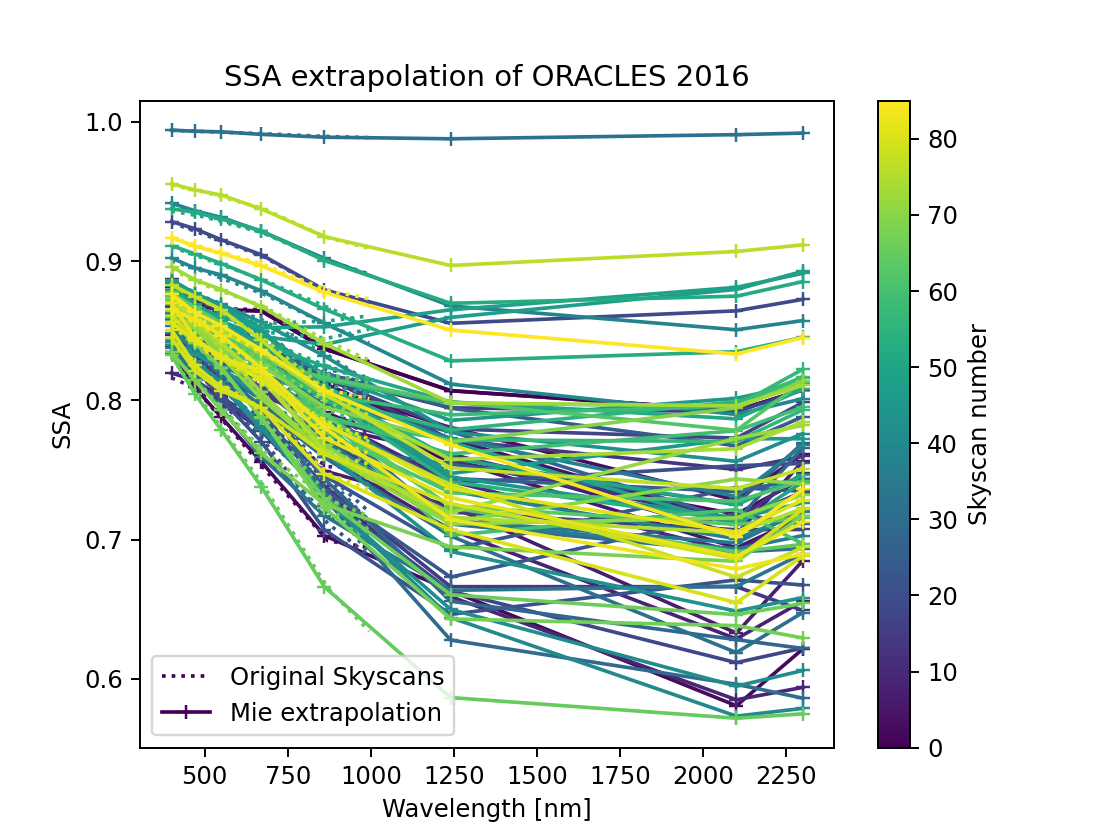

In [57]:
plt.figure()
it=0
plt.plot(ae[b'wavelength'],ae[b'SSA'][it,:],':',c=plt.cm.viridis(it*3),label='Original Skyscans')
plt.plot(wave_out,dats[it]['ssa'],'+-',c=plt.cm.viridis(it*3),label='Mie extrapolation')
for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'SSA'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,dats[it]['ssa'],'+-',c=plt.cm.viridis(it*3))
plt.legend()
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,norm=plt.Normalize(vmin=0,vmax=it))
plt.colorbar(sm,label='Skyscan number')
plt.title('SSA extrapolation of ORACLES 2016')
plt.xlabel('Wavelength [nm]')
plt.ylabel('SSA')
plt.savefig(fpt+'SSA_mie_extrapolation_ORACLES2016_{}.png'.format(vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


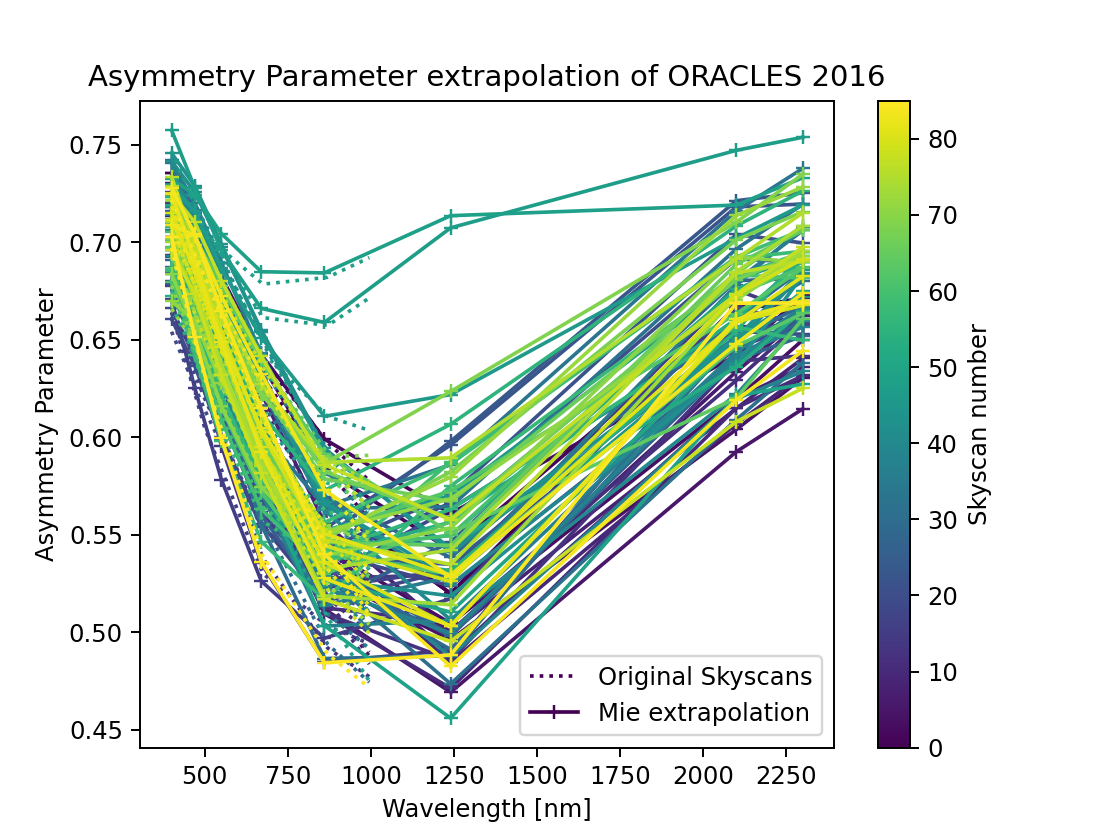

In [58]:
plt.figure()
it=0
plt.plot(ae[b'wavelength'],ae[b'g_total'][it,:],':',c=plt.cm.viridis(it*3),label='Original Skyscans')
plt.plot(wave_out,dats[it]['asym'],'+-',c=plt.cm.viridis(it*3),label='Mie extrapolation')
for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'g_total'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,dats[it]['asym'],'+-',c=plt.cm.viridis(it*3))
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,norm=plt.Normalize(vmin=0,vmax=it))
plt.colorbar(sm,label='Skyscan number')
plt.title('Asymmetry Parameter extrapolation of ORACLES 2016')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Asymmetry Parameter')
plt.legend()
    
plt.savefig(fpt+'ASYM_mie_extrapolation_ORACLES2016_{}.png'.format(vv),dpi=600,transparent=True)

## Save as netcdf

### Copy file data and attributes from older one

In [184]:
fpt = '/data/sam/TASNPP/ORACLES_aerosol_prop/'
f_out = fpt + '4STAR-aeroinv_mie_wavelength_expansion_P3_2016_R2.nc'

In [185]:
f_out

'/data/sam/TASNPP/ORACLES_aerosol_prop/4STAR-aeroinv_mie_wavelength_expansion_P3_2016_R2.nc'

In [186]:
f_in = fpt +  '4STAR-aeroinv_mie_wavelength_expansion_P3_2016_R1.nc'

In [187]:
toexclude = ['ExcludeVar1', 'ExcludeVar2']

with nc.Dataset(f_in) as src, nc.Dataset(f_out, "w") as dst:
    # copy global attributes all at once via dictionary
    dst.setncatts(src.__dict__)
    # copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(
            name, (len(dimension) if not dimension.isunlimited() else None))
    # copy all file data except for the excluded
    for name, variable in src.variables.items():
        if name not in toexclude:
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            # copy variable attributes all at once via dictionary
            dst[name].setncatts(src[name].__dict__)
            dst[name][:] = src[name][:]
            

### Update the Dataset with the new calculated ssa/asym

In [195]:
fn = nc.Dataset(f_out,'a')

In [196]:
fn

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    PI: Jens Redemann
    Institution: NASA Ames Research Center
    Instrument: Spectrometers for Sky-Scanning, Sun-Tracking Atmospheric Research (4STAR)
    Mission: ORACLES 2016
    PI_CONTACT_INFO: jredemann@ou.edu
    PLATFORM: NASA P3
    LOCATION: Based at Walvis Bay, Namibia, aircraft latitude, longitude, altitude are included in the data records
    DATA_INFO: Measurements represent airborne retrievals of aerosol properties derived from direct beam and angularly-resolved sky radiances at the location of the aircraft in the direction indicated by Az_sky and El_sky.  All measurements used in a single retrieval are reported at the time averaged over the sky scan.
    RETRIEVAL_INFO: Retrieval code was provided by AERONET (version 2 Aerosol Inversions), input files modified for airborne application.
    RETRIEVAL_DESCRIPTION: https://aeronet.gsfc.nasa.gov/new_web/Documents/Inversion_products_V2.p

In [197]:
fn.getncattr('REVISION')

'R1'

In [198]:
if vv=='v2':
    fn.setncattr('REVISION',"R1")
    fn.setncattr('R1',"Same measurement values as R0. Update to include phase function moments of extrapolated values, and expanded wavelengths")
    fn.setncattr('History',"Modified By Samuel LeBlanc, 2022-09-21: Expanded wavelengths extrapolation and included phase function moments.\nModified By Samuel LeBlanc, 2022-09-14, to add wavelength-extrapolated SSA and Asymmetry Parameter, using Mie calculations of size distribution and extrapolated index of refraction")
elif vv=='v3':
    fn.setncattr('REVISION',"R2")
    fn.setncattr('R1',"Same measurement values as R0. Update to include phase function moments of extrapolated values, and expanded wavelengths")
    fn.setncattr('R2',"Same measurement and expanded phase moments and extrapolated values from R1. Update to include QC flags from Pistone et al.")
    fn.setncattr('History',"Modified By Samuel LeBlanc, 2022-10-04: Added QC flags from Pistone et al., 2019 .\n Modified By Samuel LeBlanc, 2022-09-21: Expanded wavelengths extrapolation and included phase function moments.\nModified By Samuel LeBlanc, 2022-09-14, to add wavelength-extrapolated SSA and Asymmetry Parameter, using Mie calculations of size distribution and extrapolated index of refraction")
else:
    fn.setncattr('History',"Modified By Samuel LeBlanc, 2022-09-14, to add wavelength-extrapolated SSA and Asymmetry Parameter, using Mie calculations of size distribution and extrapolated index of refraction")
    

In [69]:
fn.createDimension('Extrap_wavelength',len(dats[0]['wavelength']))
fn.createVariable('Extrap_wavelength','float64',('Extrap_wavelength'))
fn['Extrap_wavelength'].setncatts({'long_name':'Wavelengths from the extrapolated mie calculations','units':'nm'})
fn['Extrap_wavelength'][:] = dats[0]['wavelength'][:]

In [78]:
extraps = {}


extraps['n_real'] = {'data':np.array([da['n_real'] for da in dats]),
                     'atts':{'long_name':'Real refractive index, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-21'}}
extraps['n_imag'] = {'data':np.array([da['n_imag'] for da in dats]),
                     'atts':{'long_name':'Imaginary refractive index, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-21'}}
extraps['qext'] = {'data':np.array([da['qext'] for da in dats]),
                     'atts':{'long_name':'extinction efficiency factor, extrapolated in wavelength by Mie calculations',
                             'units':'cm^3/m^3',
                             'history':'Built by Samuel LeBlanc on 2022-09-21'}}
extraps['ssa'] = {'data':np.array([da['ssa'] for da in dats]),
                     'atts':{'long_name':'Single Scattering Albedo, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-21'}}
extraps['asym'] = {'data':np.array([da['asym'] for da in dats]),
                     'atts':{'long_name':'Asymmetry Parameter, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-21'}}
extraps['pmom'] = {'data':np.array([da['pmom'] for da in dats]),
                     'atts':{'long_name':'Phase function Legendre moments (km) for the phase function(p(µ)) reconstruction using: p(µ) = Sum((2m + 1) · km · Pm(µ)) for m=0 to infinity',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-21'}}


In [79]:
len(dats[0]['pmom'][0,:])

1501

In [80]:
if vv=='v2':
    fn.createDimension('Extrap_nmom',len(dats[0]['pmom'][0,:]))
    fn.createVariable('Extrap_nmom','int',('Extrap_nmom'))
    fn['Extrap_nmom'].setncatts({'long_name':'Moment number for phase function moments','units':'None'})
    fn['Extrap_nmom'][:] = np.arange(0,len(dats[0]['pmom'][0,:]))

RuntimeError: NetCDF: String match to name in use

In [81]:
for k in extraps:
    if k == 'pmom':
        fn.createVariable('Extrap_'+k,'float',('time','Extrap_wavelength','Extrap_nmom'))
        fn['Extrap_'+k].setncatts(extraps[k]['atts'])
        fn['Extrap_'+k][:] = extraps[k]['data']
    else:
        fn.createVariable('Extrap_'+k,'float64',('time','Extrap_wavelength'))
        fn['Extrap_'+k].setncatts(extraps[k]['atts'])
        fn['Extrap_'+k][:] = extraps[k]['data']

In [199]:
if vv=='v3':
    k = 'QC_flags'
    extraps = {}
    extraps['QC_flags'] = {'data':qc_flags,
                     'atts':{'long_name':'QC of flags, lower is better. From Pistone et al., published on QC values below 1. evaluated on AOD_400>0.2, max scattering angle measured larger than 90, and low mean sky error (below~5)',
                             'units':'None',
                             'history':'Built by Pistone et al., and incorporated into file on 2022-10-04'}}

    fn.createVariable('QC_flags','float',('time'))
    fn['QC_flags'].setncatts(extraps[k]['atts'])
    fn['QC_flags'][:] = extraps[k]['data']

In [200]:
fn

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    PI: Jens Redemann
    Institution: NASA Ames Research Center
    Instrument: Spectrometers for Sky-Scanning, Sun-Tracking Atmospheric Research (4STAR)
    Mission: ORACLES 2016
    PI_CONTACT_INFO: jredemann@ou.edu
    PLATFORM: NASA P3
    LOCATION: Based at Walvis Bay, Namibia, aircraft latitude, longitude, altitude are included in the data records
    DATA_INFO: Measurements represent airborne retrievals of aerosol properties derived from direct beam and angularly-resolved sky radiances at the location of the aircraft in the direction indicated by Az_sky and El_sky.  All measurements used in a single retrieval are reported at the time averaged over the sky scan.
    RETRIEVAL_INFO: Retrieval code was provided by AERONET (version 2 Aerosol Inversions), input files modified for airborne application.
    RETRIEVAL_DESCRIPTION: https://aeronet.gsfc.nasa.gov/new_web/Documents/Inversion_products_V2.p

In [201]:
fn.close()

# Calculate the phase functions

In [88]:
import subprocess

In [101]:
base = 'mie_ORACLES2016_expansion_{}'.format(vv)
f_list = fp_rtm+base+'_list_for_phase.sh'
with open(f_list,'w') as f:
    for it,tt in list(enumerate(ae[b'time'])):
        basename = base+'_{:03.0f}'.format(it)
        # loop through and copy file to delete first line
        for i,w in list(enumerate(wave_out)):
            if i==0:
                subprocess.call("sed '/^$/d' "+fp_rtm+basename+".out > "+fp_rtm+basename+"_w{:1.0f}.out".format(i),shell=True) # remove empty lines
            else:
                subprocess.call("sed '1d' "+fp_rtm+basename+"_w{:1.0f}.out > ".format(i-1)+fp_rtm+basename+"_w{:1.0f}.out".format(i),shell=True)
            f.write('{bin_path}phase {inp} > {out}\n'.format(bin_path=fp_bin,inp=fp_rtm+basename+'_w{:1.0f}.out'.format(i),out=fp_rtm+basename+'_phase_w{:1.0f}.out'.format(i)))

In [87]:
wave_out

array([ 400.,  470.,  550.,  670.,  860., 1240., 2100., 2300.])

In [102]:
!parallel --jobs=22 --bar < $f_list

0% 0:688=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP_ ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_000_w0.out
 ... processing only 1st line!
0% 1:687=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP_ ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_000_w1.out
 ... processing only 1st line!
0% 2:686=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP_ ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_000_w2.out
 ... processing only 1st line!
0% 3:685=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP_ ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_000_w3.out
 ... processing only 1st line!
0% 4:684=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP_ ... read 4 line

6% 46:642=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_005_w6.out
 ... processing only 1st line!
6% 47:641=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_005_w7.out
6% 48:640=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_006_w0.out
 ... processing only 1st line!
7% 49:639=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_006_w1.out
 ... processing only 1st line!
7% 50:638=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNPP ... read 6 lines with 1501 coefficients each f

12% 83:605=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_010_w3.out
 ... processing only 1st line!
12% 84:604=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_010_w4.out
 ... processing only 1st line!
12% 85:603=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_010_w5.out
 ... processing only 1st line!
12% 86:602=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_010_w6.out
 ... processing only 1st line!
12% 87:601=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 1 line

17% 123:565=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_015_w3.out
 ... processing only 1st line!
18% 124:564=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_015_w4.out
 ... processing only 1st line!
18% 125:563=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_015_w5.out
 ... processing only 1st line!
18% 126:562=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_015_w6.out
 ... processing only 1st line!
18% 127:561=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 line

23% 161:527=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_020_w1.out
 ... processing only 1st line!
23% 162:526=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_020_w2.out
 ... processing only 1st line!
23% 163:525=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_020_w3.out
 ... processing only 1st line!
23% 164:524=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_020_w4.out
 ... processing only 1st line!
23% 165:523=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 line

28% 196:492=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_024_w4.out
 ... processing only 1st line!
28% 197:491=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_024_w5.out
 ... processing only 1st line!
28% 198:490=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_024_w6.out
 ... processing only 1st line!
28% 199:489=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_024_w7.out
29% 200:488=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each f

33% 233:455=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_029_w1.out
 ... processing only 1st line!
34% 234:454=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_029_w2.out
 ... processing only 1st line!
34% 235:453=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_029_w3.out
 ... processing only 1st line!
34% 236:452=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_029_w4.out
 ... processing only 1st line!
34% 237:451=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 line

39% 271:417=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_033_w7.out
39% 272:416=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_034_w0.out
 ... processing only 1st line!
39% 273:415=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_034_w1.out
 ... processing only 1st line!
39% 274:414=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_034_w2.out
 ... processing only 1st line!
39% 275:413=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each f

47% 325:363=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_040_w5.out
 ... processing only 1st line!
47% 326:362=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_040_w6.out
 ... processing only 1st line!
47% 327:361=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_040_w7.out
47% 328:360=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_041_w0.out
 ... processing only 1st line!
47% 329:359=1s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each f

54% 375:313=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_046_w7.out
54% 376:312=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_047_w0.out
 ... processing only 1st line!
54% 377:311=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_047_w1.out
 ... processing only 1st line!
54% 378:310=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_047_w2.out
 ... processing only 1st line!
55% 379:309=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each f

59% 412:276=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_051_w4.out
 ... processing only 1st line!
60% 413:275=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_051_w5.out
 ... processing only 1st line!
60% 414:274=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_051_w6.out
 ... processing only 1st line!
60% 415:273=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_051_w7.out
60% 416:272=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each f

65% 453:235=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_056_w5.out
 ... processing only 1st line!
65% 454:234=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_056_w6.out
 ... processing only 1st line!
66% 455:233=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_056_w7.out
66% 456:232=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_057_w0.out
 ... processing only 1st line!
66% 457:231=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each f

71% 491:197=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_061_w3.out
 ... processing only 1st line!
71% 492:196=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_061_w4.out
 ... processing only 1st line!
71% 493:195=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_061_w5.out
 ... processing only 1st line!
71% 494:194=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_061_w6.out
 ... processing only 1st line!
71% 495:193=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 line

76% 528:160=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_066_w0.out
 ... processing only 1st line!
76% 529:159=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_066_w1.out
 ... processing only 1st line!
77% 530:158=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_066_w2.out
 ... processing only 1st line!
77% 531:157=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 5 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_066_w3.out
 ... processing only 1st line!
77% 532:156=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 4 line

82% 565:123=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_070_w5.out
 ... processing only 1st line!
82% 566:122=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_070_w6.out
 ... processing only 1st line!
82% 567:121=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_070_w7.out
82% 568:120=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_071_w0.out
 ... processing only 1st line!
82% 569:119=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASN ... read 7 lines with 1501 coefficients each f

87% 604:84=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 4 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_075_w4.out
 ... processing only 1st line!
87% 605:83=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 3 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_075_w5.out
 ... processing only 1st line!
88% 606:82=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 2 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_075_w6.out
 ... processing only 1st line!
88% 607:81=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_075_w7.out
88% 608:80=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 8 lines with 1501 coefficients each f

92% 639:49=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 1 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_079_w7.out
93% 640:48=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 8 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_080_w0.out
 ... processing only 1st line!
93% 641:47=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 7 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_080_w1.out
 ... processing only 1st line!
93% 642:46=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 6 lines with 1501 coefficients each from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_v2_080_w2.out
 ... processing only 1st line!
93% 643:45=0s /home/sam/libradtran/libRadtran-2.0.2/bin/phase /scratch/rtm/TASNP ... read 5 lines with 1501 coefficients each f

## Read the output phase function files

In [ ]:
ph1 = np.genfromtxt(fp_rtm+basename+'_phase_w{:1.0f}.out'.format(i))

In [122]:
phase = np.zeros((len(ae[b'time']),len(wave_out),len(ph1[:,0])))+np.nan
iphase = np.zeros((len(ae[b'time']),len(wave_out),len(ph1[:,0])))+np.nan
mu = ph1[:,0]
scat_angle = np.arccos(mu)*180.0/np.pi

In [123]:
base = 'mie_ORACLES2016_expansion_{}'.format(vv)
for it,tt in list(enumerate(ae[b'time'])):
    basename = base+'_{:03.0f}'.format(it)
    for i,w in list(enumerate(wave_out)):
        ph = np.genfromtxt(fp_rtm+basename+'_phase_w{:1.0f}.out'.format(i))
        phase[it,i,:] = ph[:,1]
        iphase[it,i,:] = ph[:,2]

In [125]:
phase.shape

(86, 8, 201)

In [129]:
from mpltools import color

<IPython.core.display.Javascript object>


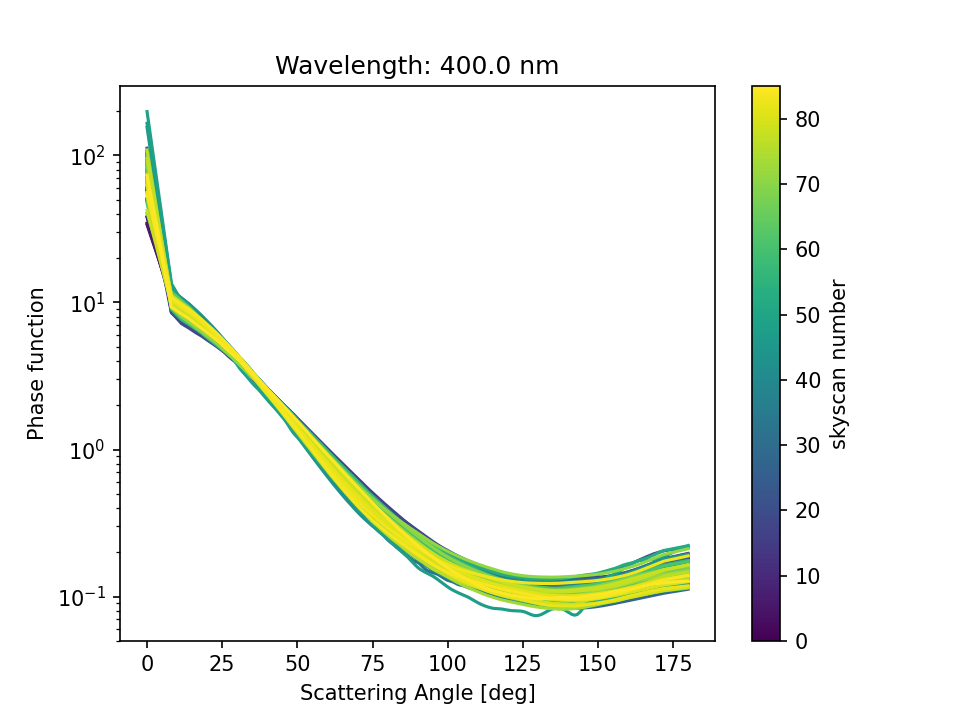

<IPython.core.display.Javascript object>


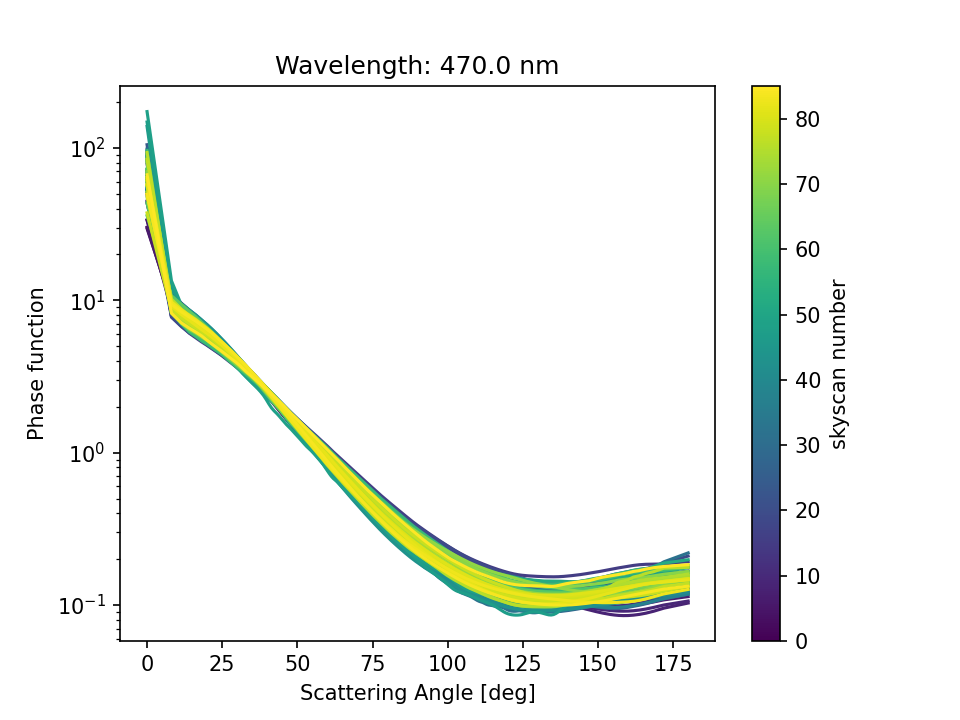

<IPython.core.display.Javascript object>


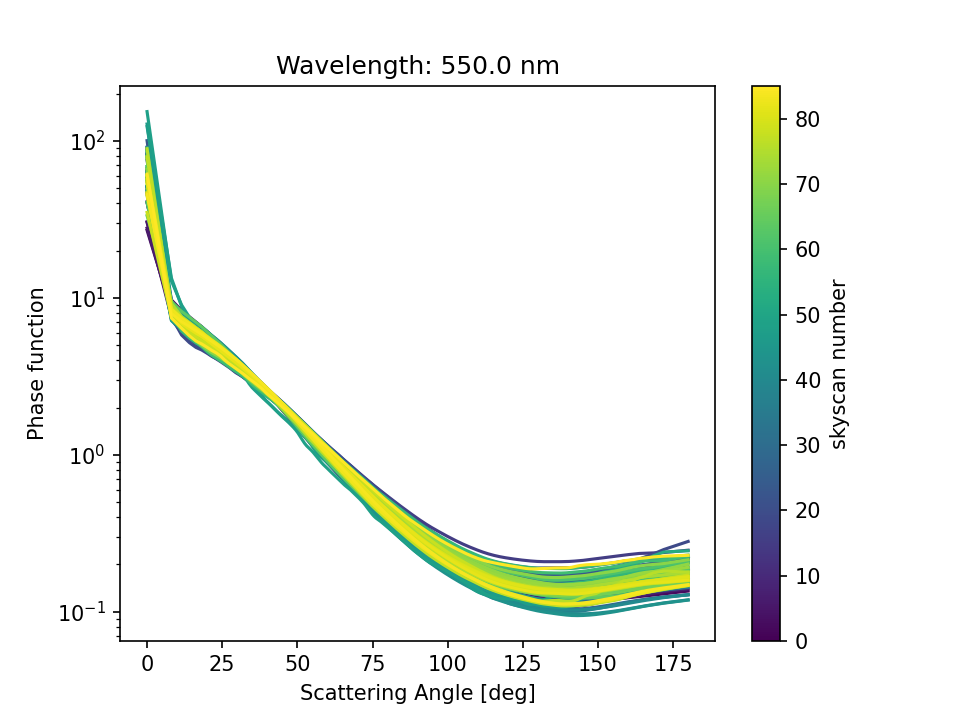

<IPython.core.display.Javascript object>


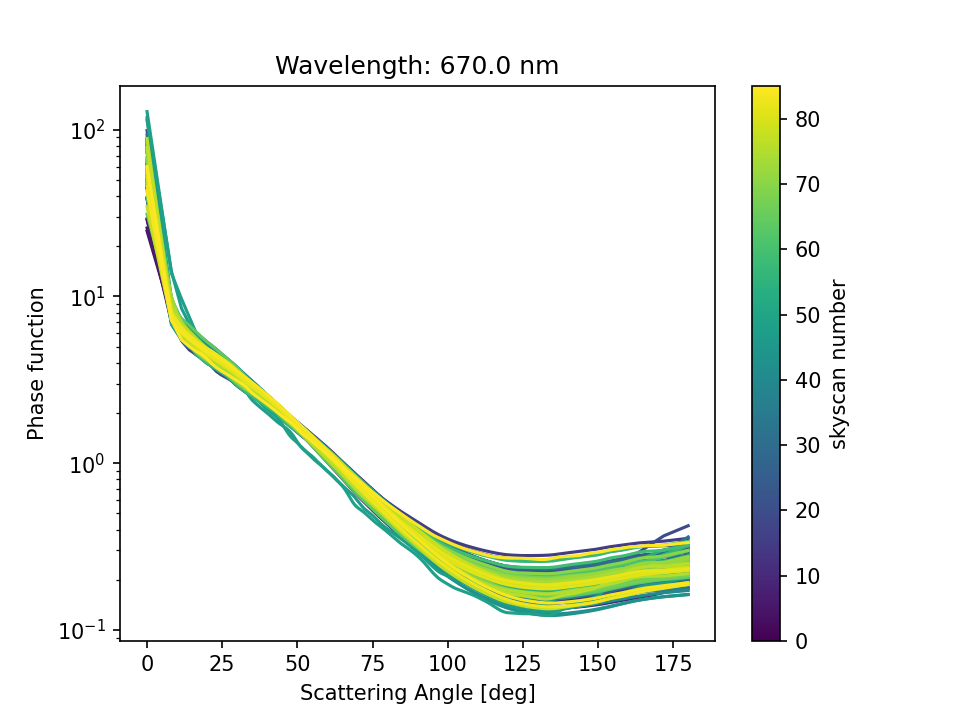

<IPython.core.display.Javascript object>


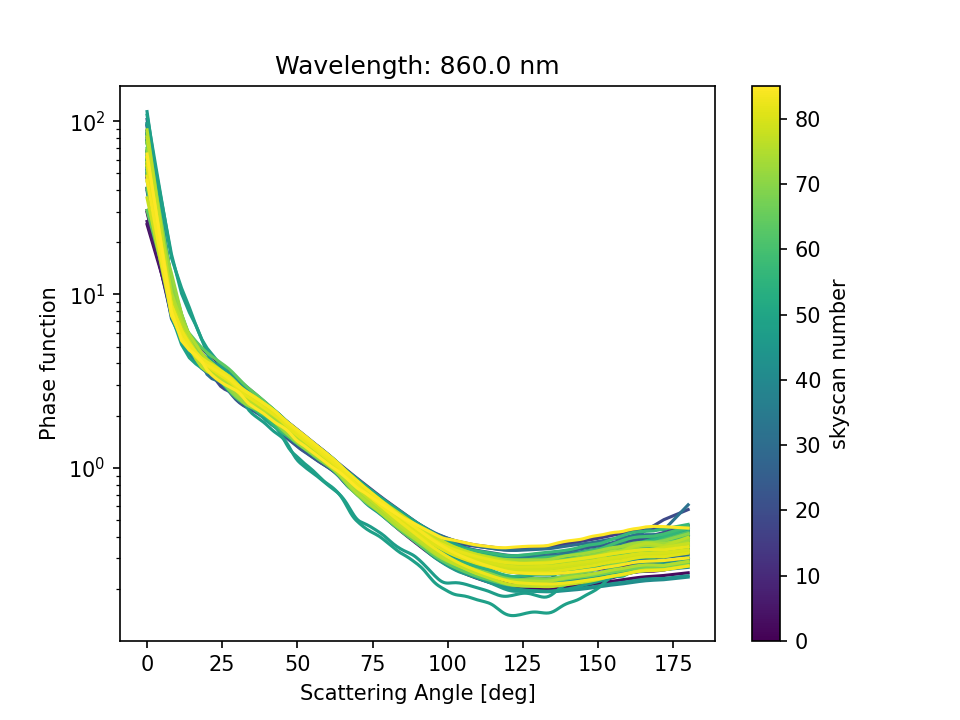

<IPython.core.display.Javascript object>


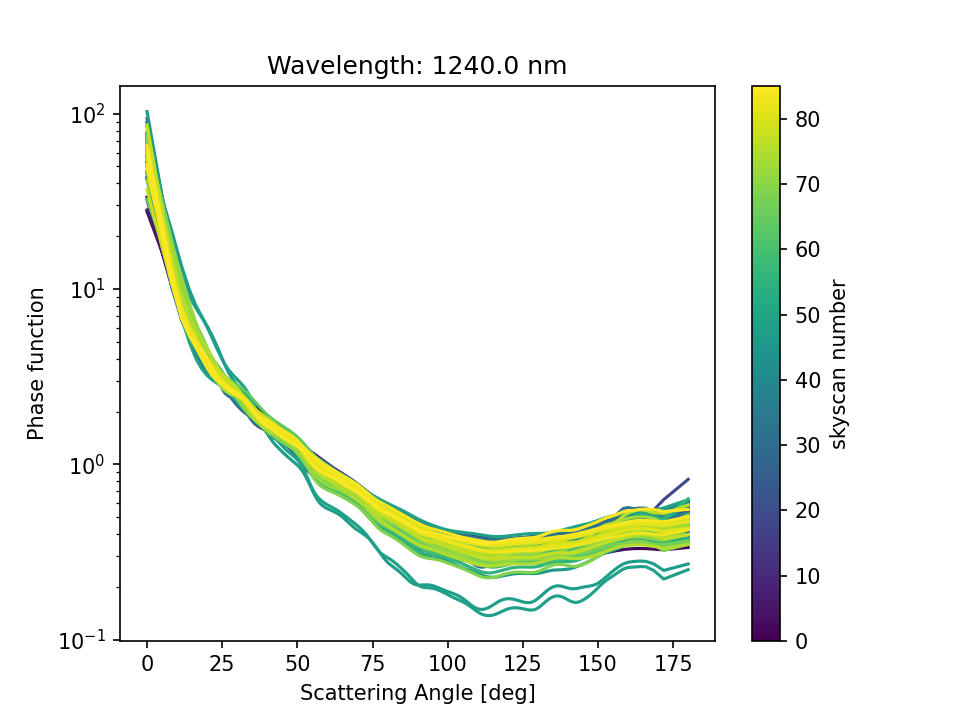

<IPython.core.display.Javascript object>


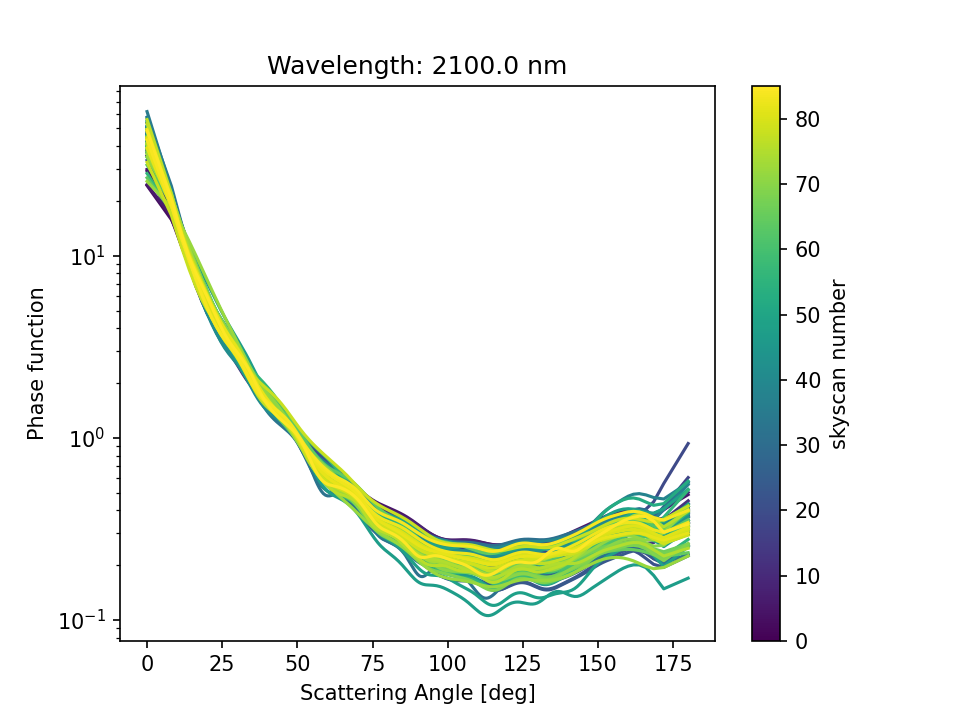

<IPython.core.display.Javascript object>


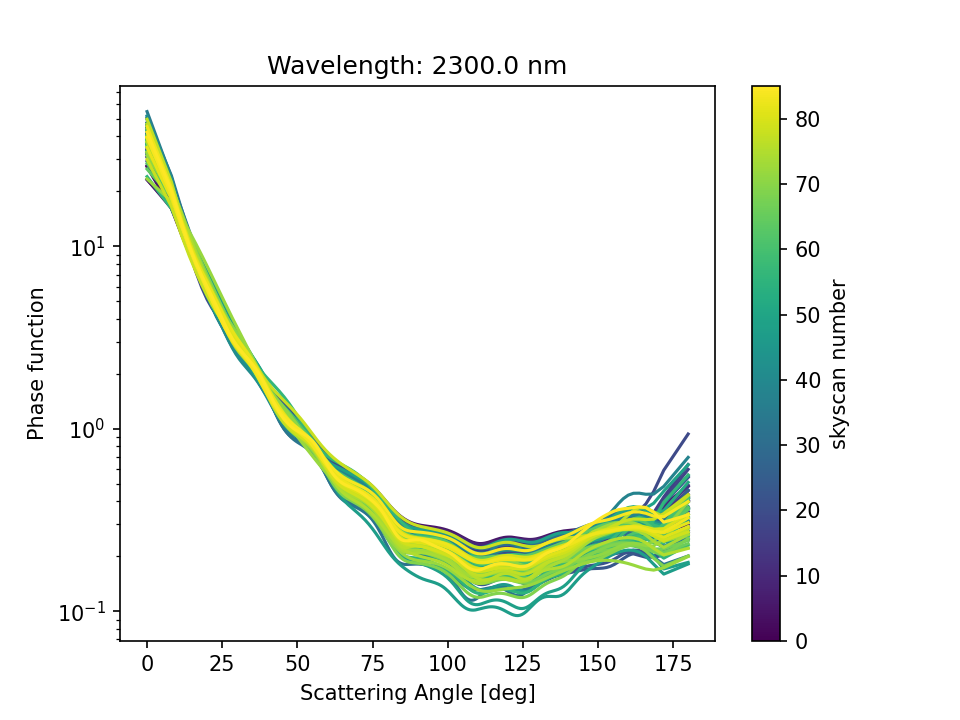

In [131]:
for i,w in list(enumerate(wave_out)):
    plt.figure()
    color.cycle_cmap(len(ae[b'time']),cmap=plt.cm.viridis,ax=plt.gca())
    plt.plot(scat_angle,phase[:,i,:].T)
    plt.xlabel('Scattering Angle [deg]')
    plt.ylabel('Phase function')
    plt.yscale('log')
    plt.title('Wavelength: {:4.1f} nm'.format(w))

    scalarmap = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    scalarmap.set_array(range(len(ae[b'time'])))
    cba = plt.colorbar(scalarmap,label='skyscan number')
